# Regression 

Regression is a very old method that calculate the relationship between responses and corresponding explanatory variables.
For linear regression analysis, which is always the beginning guess if models are not specified, it present the statistical significance if pvalue is below 5% significance level. 



# Initialization


In [1]:

# Initialization
import dcor
import numpy as np
import pickle
import itertools
import pandas as pd
import os
import math
from tqdm.notebook import tqdm
from multiprocessing import pool
import geopandas


import sys
import pysal
from pysal.model.spreg import ols, ml_error, ml_lag
from libpysal.weights import W
import libpysal

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from community import community_louvain as community

from dcor._dcor_internals import _u_distance_matrix, u_complementary_projection
from sklearn.manifold import MDS
import gc
import warnings 
warnings.filterwarnings('ignore')

std_values = pickle.load(open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\dict_all_i_wb.pkl', 'rb'))

C:\Users\ALIENWARE\anaconda3\envs\tf\lib\site-packages\numba\np\ufunc\parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)
C:\Users\ALIENWARE\anaconda3\envs\tf\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\ALIENWARE\anaconda3\envs\tf\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# Data Preparation

In [2]:
# loading original and standardised data set
dict_all = pickle.load(open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\dict.pkl', 'rb'))
dict_all_std = pickle.load(open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\dict_std.pkl', 'rb'))
variable=dict_all_std['Darlington'].index
year = dict_all_std['Darlington'].columns

# Data Preparation
#data preparation
continents_prep_g = {}

#loading authorityname and dataset
EMPLOYMENT = pd.read_csv("EMPLOYMENT.csv",dtype = "object",na_values=["*","-","!"],skiprows=6)

Employmentall = EMPLOYMENT.dropna(subset=["row"])
a = ['row']
Employmentall = Employmentall[~Employmentall['row'].isin(a)]
Employmentall['year']=0
for i in range(17):
    Employmentall['year'][i*206:(i+1)*206] = 2004+i

#recall authorityname
authoritynames = list(Employmentall['local authority: county / unitary (as of April 2021)'].unique())
#remove the authority with all nan values
authoritynames.remove('Isles of Scilly')


In [3]:
variable

Index(['Economic activity rate - aged 16-64', 'Employment rate - aged 16-64',
       '% aged 16-64 who are employees', '% aged 16-64 who are self employed',
       'Unemployment rate - aged 16-64', 'Unemployment rate - aged 16+',
       '% who are economically inactive - aged 16-64',
       '% of economically inactive who want a job',
       '% of economically inactive who do not want a job',
       'Economic activity rate males - aged 16-64',
       'Employment rate males - aged 16-64',
       '% of males aged 16-64 who are employees',
       '% of males aged 16-64 who are self employed',
       'Unemployment rate males - aged 16-64',
       'Unemployment rate males - aged 16+',
       '% of  males who are economically inactive - aged 16-64',
       '% of economically inactive males who want a job',
       '% of economically inactive males who do not want a job',
       'Economic activity rate females - aged 16-64',
       'Employment rate females - aged 16-64',
       '% of females a

In [4]:
#this accounts for all variables with unemployment and earnings
variablelen = [0,4, 27, 28, 29, 30, 31,32,33,34,35, 39,-9,-6, -3,-2,-1 ]
#number of total variables
len(variablelen)

#this is all potential x variables excluding unemployment
xvariable = [0, 27, 28, 29, 30, 31,32,33,34,35, 39,-9,-6, -3 ]

#this is all potential x variables excluding unemployment and median earnings but with upper quantile earnings
xvariable_upperquant = [0, 27, 28, 29, 30, 31,32,33,34,35, 39,-9,-4, -3 ]


#this is all potential x variables excluding unemployment and median earnings but with lower quantile earnings
xvariable_lowerquant = [0, 27, 28, 29, 30, 31,32,33,34,35, 39,-9,-5, -3 ]


# Computation of Pearson and comparison with distance correlation

In [5]:
#define how to calculate pearson correlation
def correlation_coefficient(T1, T2):
    numerator = np.mean((T1 - T1.mean()) * (T2 - T2.mean()))
    denominator = T1.std() * T2.std()
    if denominator == 0:
        return 0
    else:
        result = numerator / denominator
        return result

In [6]:
yearval = range(2008,2021)

def distance_cor(row):
    #create an empty dataframe
    subset = pd.DataFrame(data = np.zeros([len(yearval),3]),columns=['year','dcor','pearson'])
    
    pair_0, pair_1 = row
    #arrange values so that it will become matrices with year as columns and authroity(region) as rows
    pair_0_array_all=np.zeros([len(authoritynames),len(yearval)])
    pair_1_array_all=np.zeros([len(authoritynames),len(yearval)])
    for i in range(len(authoritynames)):
        authority = authoritynames[i]
        for j in range(len(yearval)):
            year = yearval[j]
            pair_0_array_all[i,j] = std_values[authority].loc[pair_0,:][year]
            pair_1_array_all[i,j] = std_values[authority].loc[pair_1,:][year]
    #Calculate distance correlation and pearson correlation
    for i in range(len(yearval)):
        subset.iloc[i,0] = int(yearval[i])
        subset.iloc[i,1] = dcor.distance_correlation(pair_0_array_all[:,i], pair_1_array_all[:,i])
        subset.iloc[i,2] = correlation_coefficient(pair_0_array_all[:,i], pair_1_array_all[:,i])
    return subset


In [7]:
unemploymentearningsdcor = distance_cor(['Unemployment rate - aged 16-64', 'earnings'])
unemploymentearningsdcor


,year,dcor,pearson
0,2008.0,0.093099,0.060703
1,2009.0,0.148761,-0.097950
2,2010.0,0.152815,-0.143217
3,2011.0,0.139145,-0.113364
4,2012.0,0.108170,-0.073862
5,2013.0,0.165605,0.045800
6,2014.0,0.137641,-0.042503
7,2015.0,0.120337,0.000152
8,2016.0,0.160805,0.132599
9,2017.0,0.110169,0.013449


In [8]:
# preparing pair_0 and pair_1
             
    
pair_0_mat=np.zeros([len(authoritynames),len(std_values['Darlington'].loc['earnings',:][4:])])
pair_1_mat=np.zeros([len(authoritynames),len(std_values['Darlington'].loc['Unemployment rate - aged 16-64',:][4:])])
for ind in range(len(authoritynames)):
        #only take 2008 onwards data
        pair_0_mat[ind] = std_values[authoritynames[ind]].loc['earnings',:][4:]
        pair_1_mat[ind] = std_values[authoritynames[ind]].loc['Unemployment rate - aged 16-64',:][4:]
        
print(f"pairwise distance correlation of unemployment and earnings for panel data is {dcor.distance_correlation(pair_0_mat, pair_1_mat)}")
print(f"Pearson correlation of unemployment and earnings for panel data is {correlation_coefficient(pair_0_mat, pair_1_mat)}")



pairwise distance correlation of unemployment and earnings for panel data is 0.4334879490979441
Pearson correlation of unemployment and earnings for panel data is -0.5721486944912192


Can easily see that for some year, the distance correlation and the absolute value of pearson correlation are very close to each other whereas some year they are not. This will be quite interesting if we check linear regression can show the similar result of significance of unemployment and earning.

# Linear regression for unemployment and earning only
For all data we have, we consider the relation between unemployment and earning for each year from 2008 to 2020. Now first, take the yvalue to be unemployment and x value to be earnings. Here we define a function:

In [9]:
def Initializationforveclinreg(yeari):
    #first, compute yvec corresponding unemployment for year i. Initialize it
    yvec = np.zeros([len(authoritynames),1])
    #Plug in the values for yvec
    for j in range(len(authoritynames)):
        #only take yeari data
        yvec[j] = std_values[authoritynames[j]].iloc[4,yeari]

    #now, compute xvec corresponding earnings for yeari. Initialize it. Note xvec is 205*2 matrix, in which the first column is all ones,
    #corresponding to interception. 
    xvec = np.zeros([len(authoritynames),2])
    #Plug in the values for xvec, here the first column all equal to one
    xvec[:,0] = 1

    for j in range(len(authoritynames)):
        #only take yeari data
        xvec[j,1] = std_values[authoritynames[j]].iloc[-6,yeari]
    return yvec, xvec



Can first calculate the linear regression for unemployment and earnings in 2008 to have a check: (2008 corresponds to the fourth column of std_values)

In [10]:
import statsmodels.api as sm

#Compute the regression using sklearn
yvec2008,xvec2008=Initializationforveclinreg(4)
resultsvec2008 = sm.OLS(yvec2008,xvec2008).fit()
#get the pvalue for coefficient between unemployment and earnings
print(f'The pvalue between unemployment and earnings is {resultsvec2008.pvalues[1]}')

The pvalue between unemployment and earnings is 0.387250606268407


Now we compute all the pvalues for year from 2008 to 2020 to compare with the one with distance correlation. 

In [11]:
#Initialize a vector with 13 years of pvalue
linreg_twovar = np.zeros(13)
linreg_coeff = np.zeros(13)
linreg_se = np.zeros(13)
#iterate over years from year 2008 to 2020: (2008 corresponds to 4th column of stdvalue and 2020 corresponds to 17th column of stdvalue)
for i in range(4,17):    
    #compute all regression using initialized function for xvec and yvec 
    yvec,xvec = Initializationforveclinreg(i)
    resultsvec = sm.OLS(yvec,xvec).fit()
    #get the pvalue for coefficient between unemployment and earnings for year i 
    linreg_twovar[i-4] = resultsvec.pvalues[1]
    linreg_coeff[i-4] = resultsvec.params[1]
    linreg_se[i-4] = resultsvec.bse[1]
#show the result
linreg_twovar


array([0.38725061, 0.16234764, 0.04050262, 0.10557168, 0.29256493,
       0.51434783, 0.54510657, 0.99827726, 0.05805257, 0.8482197 ,
       0.03594898, 0.06420104, 0.20564924])

In [12]:
#create an empty dataframe
linreg_twovardf = pd.DataFrame(data = np.zeros([len(list(range(2008,2021))),4]),columns=['year','coefficient','linreg_p_value','standard error'])
#Plug values into dataframe to make a better visualization of the result
linreg_twovardf.iloc[:,0] = list(range(2008,2021))
linreg_twovardf.iloc[:,1] = linreg_coeff
linreg_twovardf.iloc[:,2] = linreg_twovar
linreg_twovardf.iloc[:,3] = linreg_se

linreg_twovardf


,year,coefficient,linreg_p_value,standard error
0,2008,0.046773,0.387251,0.053980
1,2009,-0.128243,0.162348,0.091451
2,2010,-0.234369,0.040503,0.113673
3,2011,-0.156387,0.105572,0.096199
4,2012,-0.121163,0.292565,0.114819
5,2013,0.083525,0.514348,0.127864
6,2014,-0.072123,0.545107,0.118989
7,2015,0.000229,0.998277,0.106052
8,2016,0.191334,0.058053,0.100381
9,2017,0.020598,0.848220,0.107485


Text(0.5, 1.0, 'Error bar plotting for coefficient over time')

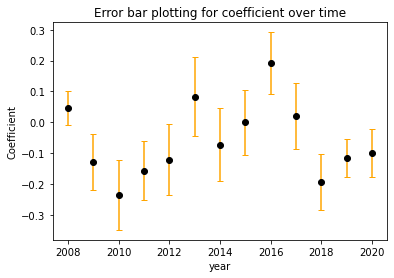

In [13]:
plt.plot()
plt.errorbar(linreg_twovardf.iloc[:,0], linreg_twovardf.iloc[:,1], yerr = linreg_twovardf.iloc[:,3],fmt = 'o',color = 'black', 
            ecolor = 'orange', capsize=3)
plt.xlabel("year")
plt.ylabel("Coefficient")
plt.title("Error bar plotting for coefficient over time")

# Linear regression for year 2020 with respect to other variables

Suppose now we only interested in 2020 unemployment and its relationship with other condition variables in the year and see if correlation between unemployment and earnings is still correlated. We take the xvariable as indicated in data preparation part. Now we can get all the values as needed


In [14]:
#first, compute ymat corresponding unemployment for year 2020. Initialize it
ymat2020 = np.zeros([len(authoritynames),1])
#Plug in the values for yvec
for j in range(len(authoritynames)):
    #only take yeari data
    ymat2020[j] = std_values[authoritynames[j]].iloc[4,-1]

#now, compute xmat corresponding earnings for 2020. Initialize it. Note  is 205*2 matrix, in which the first column is all ones,
#corresponding to interception. 
xmat2020 = np.zeros([len(authoritynames),len(xvariable)])
#initialize the first column as all ones
xmat2020[:,0] = 1
#xmat has rows with authorities and columns as xvariables
for j in range(len(xvariable)):
    for i in range(len(authoritynames)):
        #only take 2020
        xmat2020[i,j] = std_values[authoritynames[i]].iloc[xvariable[j],-1]


In [15]:
#Compute the regression using sm
resultsvec2020 = sm.OLS(ymat2020,xmat2020).fit()
resultsvec2020.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.469
Model:                            OLS   Adj. R-squared (uncentered):              0.430
Method:                 Least Squares   F-statistic:                              12.07
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                    7.85e-20
Time:                        23:57:57   Log-Likelihood:                         -232.04
No. Observations:                 205   AIC:                                      492.1
Df Residuals:                     191   BIC:                                      538.6
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0203      0.046      0.439      0.661      -0.071       0.112
x2            -0.0550      0.064     -0.865      0.388      -0.180       0.070
x3             0.0245      0.088      0.279      0.781      -0.149       0.198
x4            -0.1449      0.070     -2.076      0.039      -0.282      -0.007
x5            -0.0547      0.069     -0.790      0.431      -0.192       0.082
x6            -0.0211      0.065     -0.326      0.745      -0.149       0.107
x7            -0.0294      0.057     -0.517      0.606      -0.142       0.083
x8            -0.0223      0.057     -0.392      0.696      -0.135       0.090
x9             0.0054      0.059      0.092      0.926      -0.110       0.121
x10           -0.0777      0.060     -1.294      0.197      -0.196       0.041
x11           -0.2154      0.104     -2.079      0.039      -0.420      -0.011
x12            0.0369      0.025      1.450      0.149      -0.013       0.087
x13           -0.1454      0.065     -2.219      0.028      -0.275      -0.016
x14           -0.0083      0.069     -0.121      0.904      -0.143       0.127
==============================================================================
Omnibus:                       23.027   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.364
Skew:                           0.725   Prob(JB):                     2.55e-07
Kurtosis:                       4.204   Cond. No.                         11.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
print(f'The pvalue between unemployment and earnings is {resultsvec2020.pvalues[-2]}')

The pvalue between unemployment and earnings is 0.02763600314575705


# Linear regression for all years with respect to other variables

In [17]:
def yearlinreg(year):
    #first, compute ymat corresponding unemployment for year 2020. Initialize it
    ymat = np.zeros([len(authoritynames),1])
    #Plug in the values for yvec
    for j in range(len(authoritynames)):
        #only take yeari data
        ymat[j] = std_values[authoritynames[j]].iloc[4,year]

    #now, compute xmat corresponding earnings for 2020. Initialize it. Note  is 205*len(xvariable) matrix, in which the first column is all ones,
    #corresponding to interception. 
    xmat = np.zeros([len(authoritynames),len(xvariable)])
    #initialize the first column as all ones
    xmat[:,0] = 1
    #xmat has rows with authorities and columns as xvariables
    for j in range(len(xvariable)):
        for i in range(len(authoritynames)):
            #only take 2020
            xmat[i,j] = std_values[authoritynames[i]].iloc[xvariable[j],year]
    return ymat,xmat

In [18]:
#Initialize a dataframe with 13 years of pvalue
linreg_twovarincomedf = pd.DataFrame(data = np.zeros([len(list(range(2008,2021))),4]),columns=['year','wages_coefficient','wages_linreg_p_value','standard error'])
linreg_twovarincomedf.iloc[:,0] = list(range(2008,2021))

for i in range(13):
    ymat,xmat = yearlinreg(4+i)
    #Compute the regression using sm
    resultsvec = sm.OLS(ymat,xmat).fit()
    print(f'Year {2008+i} has result:')
    print(resultsvec.summary())
    #get the pvalue for coefficient between unemployment and earnings for year i 
    linreg_twovarincomedf.iloc[i,1] = resultsvec.params[-2]
    linreg_twovarincomedf.iloc[i,2] = resultsvec.pvalues[-2]
    linreg_twovarincomedf.iloc[i,3] = resultsvec.bse[-2]

Year 2008 has result:
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.058
Model:                            OLS   Adj. R-squared (uncentered):             -0.012
Method:                 Least Squares   F-statistic:                             0.8331
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                       0.633
Time:                        23:57:57   Log-Likelihood:                         -159.23
No. Observations:                 205   AIC:                                      346.5
Df Residuals:                     191   BIC:                                      393.0
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

Year 2012 has result:
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.607
Model:                            OLS   Adj. R-squared (uncentered):              0.578
Method:                 Least Squares   F-statistic:                              21.04
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                    1.34e-31
Time:                        23:57:58   Log-Likelihood:                         -259.76
No. Observations:                 205   AIC:                                      547.5
Df Residuals:                     191   BIC:                                      594.0
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.221
Model:                            OLS   Adj. R-squared (uncentered):              0.164
Method:                 Least Squares   F-statistic:                              3.867
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                    8.57e-06
Time:                        23:57:58   Log-Likelihood:                         -170.59
No. Observations:                 205   AIC:                                      369.2
Df Residuals:                     191   BIC:                                      415.7
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Year 2019 has result:
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.774
Model:                            OLS   Adj. R-squared (uncentered):              0.757
Method:                 Least Squares   F-statistic:                              46.73
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                    5.87e-54
Time:                        23:57:59   Log-Likelihood:                         -180.63
No. Observations:                 205   AIC:                                      389.3
Df Residuals:                     191   BIC:                                      435.8
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

In [19]:
linreg_twovarincomedf

,year,wages_coefficient,wages_linreg_p_value,standard error
0,2008,0.075874,9.973508e-02,0.045868
1,2009,-0.483154,3.080526e-09,0.077686
2,2010,-0.570242,9.195579e-11,0.083097
3,2011,-0.941236,3.309644e-25,0.078179
4,2012,-1.297439,3.541845e-28,0.099587
5,2013,-0.891028,5.192283e-11,0.127953
6,2014,-0.326688,3.005120e-03,0.108688
7,2015,-0.024385,8.220004e-01,0.108240
8,2016,0.092453,3.795306e-01,0.104964
9,2017,-0.101073,3.657401e-01,0.111481


Text(0.5, 1.0, 'Error bar plotting for coefficient over time')

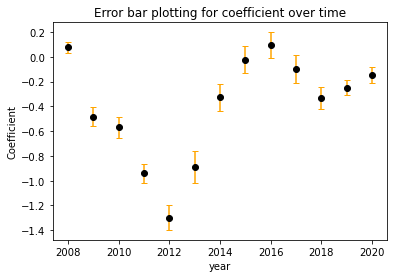

In [20]:
plt.plot()
plt.errorbar(linreg_twovarincomedf.iloc[:,0], linreg_twovarincomedf.iloc[:,1], yerr = linreg_twovarincomedf.iloc[:,3],fmt = 'o',color = 'black', 
            ecolor = 'orange', capsize=3)
plt.xlabel("year")
plt.ylabel("Coefficient")
plt.title("Error bar plotting for coefficient over time")

# Linear regression for unemployment and higher income/ lower income earning
Here we get the result for lower earnings. We take the regression pvalue for 25% quantile of earnings and make distance correlation with unemployment.

In [21]:
#initialize a function for highincome and lowincome 
def Initializationforveclinreghighincomelowincome(yeari,highincome=False,lowincome=False):
    if highincome == True:
        xvar = xvariable_upperquant
    elif lowincome == True:
        xvar = xvariable_lowerquant
        
    #first, compute yvec corresponding unemployment for year i. Initialize it
    yvec = np.zeros([len(authoritynames),1])
    #Plug in the values for yvec
    for j in range(len(authoritynames)):
        #only take yeari data
        yvec[j] = std_values[authoritynames[j]].iloc[4,yeari]

    #now, compute xvec corresponding earnings for yeari. Initialize it. Note xvec is 205*2 matrix, in which the first column is all ones,
    #corresponding to interception. 
    xmat = np.zeros([len(authoritynames),len(xvariable)])
    #Plug in the values for xvec, here the first column all equal to one
    xmat[:,0] = 1
    
    #xmat has rows with authorities and columns as xvariables
    for j in range(len(xvar)):
        for i in range(len(authoritynames)):
            #only take 2020
            xmat[i,j] = std_values[authoritynames[i]].iloc[xvar[j],yeari]
            
    
    return yvec, xmat


#### For higher income:

In [22]:
#Initialize a dataframe with 13 years of pvalue
linreg_twovarhighincomedf = pd.DataFrame(data = np.zeros([len(list(range(2008,2021))),3]),columns=['year','highincome_coefficient','highincome_linreg_p_value'])
linreg_twovarhighincomedf.iloc[:,0] = list(range(2008,2021))
#iterate over years from year 2008 to 2020: (2008 corresponds to 4th column of stdvalue and 2020 corresponds to 17th column of stdvalue)
for i in range(4,17):    
    #compute all regression using initialized function for xvec and yvec 
    yvec,xvec = Initializationforveclinreghighincomelowincome(i,highincome=True)
    resultsvec = sm.OLS(yvec,xvec).fit()
    #get the pvalue for coefficient between unemployment and earnings for year i 
    linreg_twovarhighincomedf.iloc[i-4,1] = resultsvec.params[-2]
    linreg_twovarhighincomedf.iloc[i-4,2] = resultsvec.pvalues[-2]

#show the result
linreg_twovarhighincomedf

,year,highincome_coefficient,highincome_linreg_p_value
0,2008,0.019958,5.437022e-01
1,2009,-0.462088,2.834678e-10
2,2010,-0.394803,2.449819e-06
3,2011,-0.795424,6.379808e-22
4,2012,-1.158091,9.912192e-29
5,2013,-0.960561,5.835767e-11
6,2014,-0.146554,2.065198e-01
7,2015,-0.053081,6.327081e-01
8,2016,0.008960,9.347575e-01
9,2017,-0.141362,1.758075e-01


#### For lower income

In [23]:
#Initialize a dataframe with 13 years of pvalue
linreg_twovarlowerincomedf = pd.DataFrame(data = np.zeros([len(list(range(2008,2021))),3]),columns=['year','lowincome_coefficient','lowincome_linreg_p_value'])
linreg_twovarlowerincomedf.iloc[:,0] = list(range(2008,2021))
#iterate over years from year 2008 to 2020: (2008 corresponds to 4th column of stdvalue and 2020 corresponds to 17th column of stdvalue)
for i in range(4,17):    
    #compute all regression using initialized function for xvec and yvec 
    yvec,xvec = Initializationforveclinreghighincomelowincome(i,lowincome=True)
    resultsvec = sm.OLS(yvec,xvec).fit()
    #get the pvalue for coefficient between unemployment and earnings for year i 
    linreg_twovarlowerincomedf.iloc[i-4,1] = resultsvec.params[-2]
    linreg_twovarlowerincomedf.iloc[i-4,2] = resultsvec.pvalues[-2]


#show the result
linreg_twovarlowerincomedf

,year,lowincome_coefficient,lowincome_linreg_p_value
0,2008,0.060821,1.749854e-01
1,2009,-0.283477,1.559257e-04
2,2010,-0.388367,7.180368e-06
3,2011,-0.810640,1.102718e-25
4,2012,-0.905907,4.374758e-17
5,2013,-0.908127,2.357246e-13
6,2014,-0.187748,2.075187e-02
7,2015,0.049636,5.397839e-01
8,2016,0.087913,2.797936e-01
9,2017,-0.120061,1.973854e-01


### Elasticity for income

The elasticity can be calculated by regression coefficient. The derivation is simple (according to online source): 
$$\text{Elasticity}=\frac{\text{Percentage change in X}}{\text{Percentage change in Y}}=\frac{\frac{dY}{Y}}{\frac{dX}{X}}=\frac{dY}{dX}\frac{X}{Y}=b\frac{X}{Y}$$
where X is the earnings data and Y is the unemployment data. Since $\frac{dY}{dX}$ is the coefficient in the regression model, we can call it b which is estimated by maximum likelihood estimate. The value for X and Y, however, is not a fixed value across all authorities. TJ Valentine gives a solution by taking mean value of X and Y. Thus the above formula becomes:
$$\text{Elasticity}=b\frac{\bar X}{\bar Y}$$
where $\bar X$ is the mean value of X and $\bar Y$ is the mean value of Y.

#### Elastictity For higher income:

In [24]:
elasticity_table_higher = pd.DataFrame(data = np.zeros([len(list(range(2008,2021))),2]),columns=['Year','Elasticity'])
elasticity_table_higher.iloc[:,0] = list(range(2008,2021))
for i in range(4,17):    
    #compute all regression using initialized function for xvec and yvec 
    yvec,xvec = Initializationforveclinreghighincomelowincome(i,highincome=True)
    elasticity_table_higher.iloc[i-4,1] = linreg_twovarhighincomedf.iloc[i-4,1]*np.mean(xvec)/np.mean(yvec)
print(f'mean value for higher quantile elasticity: {np.mean(elasticity_table_higher.iloc[:,1])}')
elasticity_table_higher

mean value for higher quantile elasticity: 0.04159807380469595


,Year,Elasticity
0,2008,0.080167
1,2009,0.072234
2,2010,0.058778
3,2011,0.079609
4,2012,0.073921
5,2013,0.019771
6,2014,-0.017583
7,2015,0.024145
8,2016,-0.002855
9,2017,0.039348


#### Elastictity For lower income:

In [25]:
elasticity_table_lower = pd.DataFrame(data = np.zeros([len(list(range(2008,2021))),2]),columns=['Year','Elasticity'])
elasticity_table_lower.iloc[:,0] = list(range(2008,2021))
for i in range(4,17):    
    #compute all regression using initialized function for xvec and yvec 
    yvec,xvec = Initializationforveclinreghighincomelowincome(i,highincome=True)
    elasticity_table_lower.iloc[i-4,1] = linreg_twovarlowerincomedf.iloc[i-4,1]*np.mean(xvec)/np.mean(yvec)
print(f'mean value for lower quantile elasticity: {np.mean(elasticity_table_lower.iloc[:,1])}')
elasticity_table_lower

mean value for lower quantile elasticity: 0.04799295310390831


,Year,Elasticity
0,2008,0.244304
1,2009,0.044314
2,2010,0.057819
3,2011,0.081132
4,2012,0.057824
5,2013,0.018692
6,2014,-0.022525
7,2015,-0.022578
8,2016,-0.028009
9,2017,0.033418


#### Elastictity For median income:

In [26]:
elasticity_table_median = pd.DataFrame(data = np.zeros([len(list(range(2008,2021))),2]),columns=['Year','Elasticity'])
elasticity_table_median.iloc[:,0] = list(range(2008,2021))
for i in range(4,17):    
    #compute elastictiy using coefficient calculated for median income 
    elasticity_table_median.iloc[i-4,1] = linreg_twovarincomedf.iloc[i-4,1]*np.mean(xvec)/np.mean(yvec)
print(f'mean value for median quantile elasticity: {np.mean(elasticity_table_median.iloc[:,1])}')
elasticity_table_median

mean value for median quantile elasticity: 0.23263207062426722


,Year,Elasticity
0,2008,-0.044186
1,2009,0.281367
2,2010,0.332083
3,2011,0.548133
4,2012,0.755570
5,2013,0.518894
6,2014,0.190248
7,2015,0.014201
8,2016,-0.053840
9,2017,0.058861


# Linear regression with time lag of 2 years

As suggested in paper by Ruhm, Christopher J, wage and employment alteration begin with a lag of two calendar years. And also by our result in distance correlation where some of the correlation with 2 year lags is significant, which has higher number than other lags. Therefore, we choose lag with 2 years as our analysis.

In [27]:
#define a function for xmatrix and ymatrix with different year.
def Initializationforveclinregdiffyear(yeari,yearj):
    #first, compute yvec corresponding unemployment for year i. Initialize it
    yvec = np.zeros([len(authoritynames),1])
    #Plug in the values for yvec
    for j in range(len(authoritynames)):
        #only take yeari data for unemployment
        yvec[j] = std_values[authoritynames[j]].iloc[4,yeari]
        
    #now, compute xvec corresponding earnings for yeari. Initialize it. Note xvec is 205*2 matrix, in which the first column is all ones,
    #corresponding to interception. 
    xmat = np.zeros([len(authoritynames),len(xvariable)+1])
    #Plug in the values for xvec, here the first column all equal to one
    xmat[:,0] = 1
    
    #xmat has rows with authorities and columns as xvariables
    for j in range(len(xvariable)):
        for i in range(len(authoritynames)):
            #only take 2020
            xmat[i,j] = std_values[authoritynames[i]].iloc[xvariable[j],yeari]
    for i in range(len(authoritynames)):
        xmat[i,-1] = std_values[authoritynames[i]].iloc[-6,yearj]
            
    
    return yvec, xmat



In [28]:
#Initialize a dataframe with 11*2 years of pvalue
linreg_twovardiffyeardf = pd.DataFrame(data = np.zeros([2*(len(list(range(2008,2021)))-2),4]),columns=['year_unemployment','year_earning','coefficient','linreg_p_value'])

#iterate over years from year 2008 to 2018: (2008 corresponds to 4th column of stdvalue and 2018 corresponds to 15th column of stdvalue)
#unemployment at year i+2 and earning at year i (lag by 2)
for i in range(4,15):    
    #compute all regression using initialized function for xvec and yvec but yvec with year i and yvec with year i+2
    yvec,xvec = Initializationforveclinregdiffyear(i+2,i)
    resultsvec = sm.OLS(yvec,xvec).fit()
    #get the pvalue for coefficient between unemployment year i+2 and earning year i 
    linreg_twovardiffyeardf.iloc[i-4,3] = resultsvec.pvalues[-1]
    linreg_twovardiffyeardf.iloc[i-4,0] = 2004+i+2
    linreg_twovardiffyeardf.iloc[i-4,1] = 2004+i
    linreg_twovardiffyeardf.iloc[i-4,2] = resultsvec.params[-1]

#iterate over years from year 2008 to 2018: (2008 corresponds to 4th column of stdvalue and 2018 corresponds to 15th column of stdvalue) 
#unemployment at year i and earning at year i+2 (lag by 2)
for i in range(4,15):
    #compute all regression using initialized function for xvec and yvec but yvec with year i and yvec with year i+2
    yvec,xvec = Initializationforveclinregdiffyear(i,i+2)
    resultsvec = sm.OLS(yvec,xvec).fit()
    #get the pvalue for coefficient between unemployment year i and earning year i+2, now the indices will be computed start from i-4+11 = i+7
    linreg_twovardiffyeardf.iloc[i+7,3] = resultsvec.pvalues[-1]
    linreg_twovardiffyeardf.iloc[i+7,0] = 2004+i
    linreg_twovardiffyeardf.iloc[i+7,1] = 2004+i+2
    linreg_twovardiffyeardf.iloc[i+7,2] = resultsvec.params[-1]
    

#show the result
linreg_twovardiffyeardf

,year_unemployment,year_earning,coefficient,linreg_p_value
0,2010.0,2008.0,-0.106298,8.809424e-02
1,2011.0,2009.0,-0.492653,1.527897e-07
2,2012.0,2010.0,-0.845833,1.196589e-18
3,2013.0,2011.0,-0.740442,1.457299e-17
4,2014.0,2012.0,-0.294277,3.575178e-04
5,2015.0,2013.0,0.015240,8.672481e-01
6,2016.0,2014.0,0.198190,1.128585e-01
7,2017.0,2015.0,0.026878,8.312723e-01
8,2018.0,2016.0,-0.078577,4.556035e-01
9,2019.0,2017.0,-0.272375,6.214583e-03


# Regression with respect to Time Series for different authority with unemployment and wages only



In [29]:
#Here Initialize the xmatrix and ymatrix for each authority
def Initialization_for_authority_i(i):
    yvec = np.zeros([13,1])
    yvec[:,0] = std_values[authoritynames[i]].iloc[4,4:]

    xmat = np.zeros([13,2])
    #initialize interception as a column of one
    xmat[:,0] = 1
    xmat[:,1] = std_values[authoritynames[i]].iloc[-6,4:]
    return yvec, xmat

In [30]:
authority_pvalue = pd.DataFrame(index=range(205), columns=['authorityname','coefficient','p-value'])
for i in range(205):
    #compute all regression using initialized function for xmat and yvec with respect to authority i
    yvec,xmat = Initialization_for_authority_i(i)
    resultsvec = sm.OLS(yvec,xmat).fit()
    authority_pvalue.iloc[i,2] = resultsvec.pvalues[1]
    authority_pvalue.iloc[i,1] = resultsvec.params[1]
    authority_pvalue.iloc[i,0] = authoritynames[i]
authority_pvalue

,authorityname,coefficient,p-value
0,Darlington,-0.41361,0.073276
1,County Durham,-0.539208,0.043058
2,Hartlepool,-0.584376,0.026438
3,Middlesbrough,-0.686372,0.013837
4,Northumberland,-0.137464,0.604999
...,...,...,...
200,South Ayrshire,-0.514383,0.092108
201,South Lanarkshire,-0.409121,0.031326
202,Stirling,-0.516012,0.027255
203,West Dunbartonshire,-0.901448,0.000974


For visualization:

<AxesSubplot:>

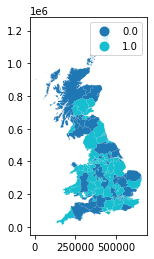

In [31]:
#create a plotting for authority
authority = geopandas.read_file('CTYUA_DEC_2021_UK_BFC.shp')

#initialize empty set
pvaluereg = np.zeros(len(authority['CTYUA21NM']))
#loop over all authority
for i in range(len(authority['CTYUA21NM'])):
    for j in range(len(authoritynames)):
        #if authorityname corresponds, get the value
        if authority['CTYUA21NM'][i]==authority_pvalue.iloc[j,0]:
            pvaluereg[i]=authority_pvalue.iloc[j,2]
            break
authority['pval'] = pvaluereg
authority = authority[authority['pval']!=0]

pvaluebull = np.zeros(len(authority['CTYUA21NM']))
for i in range(len(authority['CTYUA21NM'])):
    if pvaluereg[i]<0.05 and pvaluereg[i]!=0:
        pvaluebull[i]=1
authority['regtspval'] = pvaluebull



import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

authority.plot(column='regtspval',categorical=True, ax=ax,legend=True)

For understanding the positive or negative correlation of wages on unemployment

 Percentage of negative sign of wage coefficient in regression is 0.9852941176470589


<AxesSubplot:>

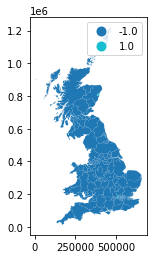

In [32]:
#create a plotting for authority
authority = geopandas.read_file('CTYUA_DEC_2021_UK_BFC.shp')

#initialize empty set
signreg = np.zeros(len(authority['CTYUA21NM']))
#loop over all authority
for i in range(len(authority['CTYUA21NM'])):
    for j in range(len(authoritynames)):
        #if authorityname corresponds, get the value
        if authority['CTYUA21NM'][i]==authority_pvalue.iloc[j,0]:
            signreg[i]=np.sign(authority_pvalue.iloc[j,1])
            break
authority['regtssign'] = signreg
authority = authority[authority['regtssign']!=0]

negval = list(signreg).count(-1)
posval = list(signreg).count(1)
print(f' Percentage of negative sign of wage coefficient in regression is {negval/(negval+posval)}')
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

authority.plot(column='regtssign',categorical=True, ax=ax, legend=True)

In [33]:
#Here we compute the percentage of authorities that has significant values and turns out to have a negative impact
#initialize negval to store authorities that is significant with negative correlation. Same for posval, which stores positive correlations for number of significant authorities.
negval = 0
posval = 0
for i in range(len(authority['regtssign'])):
    if pvaluebull[i]==1:
        if signreg[i] == -1:
            negval +=1
        elif signreg[i] == 1:
            posval+=1
print(f' Percentage of negative sign of authorities wage coefficient that is significant in regression is {negval/(negval+posval)}')

 Percentage of negative sign of authorities wage coefficient that is significant in regression is 1.0


# Multivariate linear regression for time series with respect to other variables

Suppose now we are interested in unemployment data in all years and its relationship with time series of earnings if we consider confounders in time sereis. We want to include all of the avaible data of confounders in all years and look at the relationship for unemployment and earning. Here, it is better to consider multivariate regression with more than one predictor and more than one response.

Consider the following equation:

$Y=X\beta +\Sigma$
where $\Sigma$ is the n×p matrix such that $X_i\sim \mathcal{N}(0,\Sigma)$ (multivariate normally distributed with covariance matrix $\Sigma$, Y is $n \times p$ response matrix and $X$ be an $n\times (q+1)$ matrix. Expand it out:

$\begin{pmatrix} y_{1,1}&\cdots& y_{1,p}\\
\vdots&\ddots&\vdots\\
y_{n,1}&\cdots&y_{n,p}\end{pmatrix} = \begin{pmatrix} 1&x_{1,1}&\cdots& x_{1,q}\\
\vdots&\vdots&\ddots&\vdots\\
1& x_{n,1}&\cdots&x_{n,q}\end{pmatrix}\begin{pmatrix} \beta_{0,1}&\cdots& \beta_{0,p}\\
\vdots&\ddots&\vdots\\
\beta_{q,1}&\cdots&\beta_{q,p}\end{pmatrix}+\begin{pmatrix} \epsilon_{1,1}&\cdots& \epsilon_{1,p}\\
\vdots&\ddots&\vdots\\
\epsilon_{q,1}&\cdots&\epsilon_{q,p}\end{pmatrix}$ 

This is just a superposition of:
$\begin{pmatrix} y_{1,i}\\
\vdots\\
y_{n,i}\end{pmatrix} = \begin{pmatrix} 1&x_{1,1}&\cdots& x_{1,q}\\
\vdots&\vdots&\ddots&\vdots\\
1& x_{n,1}&\cdots&x_{n,q}\end{pmatrix}\begin{pmatrix} \beta_{0,i}\\
\vdots\\
\beta_{q,i}\end{pmatrix}+\begin{pmatrix} \epsilon_{1,i}\\
\vdots\\
\epsilon_{q,i}\end{pmatrix}$ 
for $i=1,\cdots,p$.

Thus, we can calculate all regression for the above equation to get $\beta_{:,i}$ and append them together to get beta matrix. 


Here we consider the relation between unemployment and wage only in time serie data analysis. First create a function to initialize the xvariable and yvariable we required for multivariate linear regression. 

In [34]:
#Here Initialize the xmatrix and ymatrix for such model as a function. The function is for year i of the unemployment and
#it is regressed with all time series of x variables. 
def Initializationtsyearunempearningonly(i):
    yvec = np.zeros([len(authoritynames),1])
    for j in range(len(authoritynames)):
            #only take 2008 data onwards
            yvec[j,:] = std_values[authoritynames[j]].iloc[4,i]

    xmat = np.zeros([len(authoritynames),len(year[4:])+1])
    xmat[:,0] = 1
    for j in range(len(authoritynames)):
        #only take 2008 data onwards for earnings
        xmat[j,1:len(year[4:])+1] = std_values[authoritynames[j]].iloc[-6,4:]

    return yvec, xmat

In [35]:
#Initialize a dataframe with 13 years of pvalue
linreg_tsdf = pd.DataFrame(data = np.zeros([len(list(range(2008,2021)))+1,14]),columns=['variablename','beta_1','beta_2','beta_3','beta_4','beta_5','beta_6','beta_7','beta_8','beta_9','beta_10','beta_11','beta_12','beta_13'])
linreg_tsdf.iloc[0,0] = 'Constant'
for i in range(4,17):
    linreg_tsdf.iloc[i-3,0] = variable[-6]+','+str(year[i])
#iterate over years from year 2008 to 2020: (2008 corresponds to 4th column of stdvalue and 2020 corresponds to 17th column of stdvalue)
for i in range(4,17):    
    #compute all regression using initialized function for xmat and yvec 
    yvec,xmat = Initializationtsyearunempearningonly(i)
    resultsvec = sm.OLS(yvec,xmat).fit()
    #get the pvalue for coefficient between unemployment and earnings for year i 
    linreg_tsdf.iloc[:,i-3] = resultsvec.pvalues

#show the result
linreg_tsdf 

,variablename,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13
0,Constant,0.351943,0.001005,0.002348,0.002385,0.000003,0.440283,0.924750,0.822374,0.009066,0.000138,0.004734,0.035255,0.371528
1,"earnings,2008",0.541314,0.502468,0.100505,0.208165,0.906303,0.247675,0.556308,0.032916,0.097723,0.622187,0.686393,0.223144,0.166409
2,"earnings,2009",0.502030,0.050303,0.370866,0.773065,0.386662,0.933721,0.244617,0.763030,0.730143,0.495467,0.396012,0.640606,0.634014
3,"earnings,2010",0.627303,0.796117,0.067401,0.014578,0.008959,0.443167,0.157330,0.813167,0.906292,0.216099,0.688191,0.806911,0.512133
4,"earnings,2011",0.785758,0.725355,0.112005,0.904701,0.088229,0.141651,0.265979,0.845823,0.157271,0.988670,0.207667,0.224546,0.448043
5,"earnings,2012",0.778061,0.262423,0.553152,0.128754,0.141317,0.369947,0.463240,0.506434,0.409626,0.025882,0.773260,0.328180,0.003935
6,"earnings,2013",0.861655,0.774735,0.162517,0.193070,0.657653,0.415445,0.050021,0.341824,0.277262,0.091713,0.212074,0.081001,0.098619
7,"earnings,2014",0.692685,0.261713,0.858547,0.194765,0.469335,0.312604,0.085723,0.776779,0.891051,0.632566,0.324320,0.882908,0.220307
8,"earnings,2015",0.773848,0.221365,0.059592,0.821078,0.796786,0.707739,0.712806,0.800173,0.455333,0.596580,0.390166,0.570340,0.645281
9,"earnings,2016",0.480126,0.630262,0.110059,0.415929,0.924498,0.900963,0.046638,0.863978,0.640095,0.932071,0.518778,0.894858,0.853393


In [36]:
#Here Initialize the xmatrix and ymatrix for such model as a function. The function is for year i of the unemployment and
#it is regressed with all time series of x variables. 
def Initializationtsyear(i,timelength):
    yvec = np.zeros([len(authoritynames),1])
    for j in range(len(authoritynames)):
            #only take 2008 data onwards
            yvec[j,:] = std_values[authoritynames[j]].iloc[4,i]

    xmat = np.zeros([len(authoritynames),(timelength+1)*len(xvariable)+1])

    xmat[:,0] = 1
    for k in range(len(xvariable)):
        for j in range(len(authoritynames)):
            #only take 2008 data onwards
            xmat[j,(timelength+1)*k+1:(timelength+1)*(k+1)+1] = std_values[authoritynames[j]].iloc[xvariable[k],i-timelength:i+1]
            
            

    return yvec, xmat


Initializationtsyear(7,4)[1].shape

(205, 71)

In [37]:
#define time length
timelength=4

#Initialize a dataframe with 13 years of pvalue
linreg_tsdf = pd.DataFrame(data = np.zeros([len(list(range(2012,2021)))*len(xvariable)+1,6]),columns=['variablename','lag=4','lag=3','lag=2','lag=1','lag=0'])
linreg_tsdf.iloc[0,0] = 'Constant'

#Initialize a dataframe with 13 years of pvalue
linreg_tsdfpval = pd.DataFrame(data = np.zeros([len(list(range(2012,2021)))*len(xvariable)+1,6]),columns=['variablename','lag=4','lag=3','lag=2','lag=1','lag=0'])
linreg_tsdfpval.iloc[0,0] = 'Constant'

#initialize a residual matrix for use of spatial regression 
#ymat = np.zeros([205,9])
#beta_mat = np.zeros([9*timelength+1,])
Residual_mat = np.zeros([205,9])

for varind in range(len(xvariable)):
    for i in range(8,17):
        linreg_tsdf.iloc[varind*9+i-7,0] = 'Unemployment'+','+str(year[i])+', with respect to '+ variable[xvariable[varind]]
        linreg_tsdfpval.iloc[varind*9+i-7,0] = 'Unemployment'+','+str(year[i])+', with respect to '+ variable[xvariable[varind]]

        
     
#iterate over years from year 2012 to 2020: (2012 corresponds to 8th column of stdvalue and 2020 corresponds to 17th column of stdvalue)
for i in range(8,17):    
    #compute all regression using initialized function for xmat and yvec, starting from 2013
    yvec,xmat = Initializationtsyear(i,timelength)
    resultsvec = sm.OLS(yvec,xmat).fit()
    linreg_tsdf.iloc[0,5] = resultsvec.params[0]
    linreg_tsdfpval.iloc[0,5]=resultsvec.pvalues[0]
    #get the pvalue for coefficient between unemployment and earnings for year i 
    for varind in range(len(xvariable)):
        for timeind in range(timelength+1):
            linreg_tsdf.iloc[varind*9+i-7,timeind+1] = resultsvec.params[varind*(timelength+1)+1+timeind]
            linreg_tsdfpval.iloc[varind*9+i-7,timeind+1]=resultsvec.pvalues[varind*(timelength+1)+1+timeind]
            
    #in addition, we also save the residual in a huge Residual matrix
    Residual_mat[:,i-8] = np.reshape(yvec - xmat@np.reshape(resultsvec.params,[71,1]),[205])




In [38]:
#here we return the coefficient for betas for earning variables:
linreg_tsdf


,variablename,lag=4,lag=3,lag=2,lag=1,lag=0
0,Constant,0.000000,0.000000,0.000000,0.000000,-0.063819
1,"Unemployment,2012, with respect to Economic ac...",-0.024020,-0.000708,-0.014998,-0.046129,0.152611
2,"Unemployment,2013, with respect to Economic ac...",0.087247,-0.065630,0.071807,0.035595,0.038424
3,"Unemployment,2014, with respect to Economic ac...",0.115908,-0.040349,0.000512,0.063990,-0.040274
4,"Unemployment,2015, with respect to Economic ac...",0.052930,0.025419,-0.014129,-0.060664,0.083576
...,...,...,...,...,...,...
122,"Unemployment,2016, with respect to population_...",-0.293637,0.443143,-0.799287,1.144637,-0.705318
123,"Unemployment,2017, with respect to population_...",0.346879,-0.637994,0.535774,0.188480,-0.483141
124,"Unemployment,2018, with respect to population_...",-0.560459,1.067732,-0.449611,0.058287,-0.108603
125,"Unemployment,2019, with respect to population_...",-0.210105,-0.242317,0.752134,-0.333991,-0.038007


In [39]:
#here we return the pvalue for betas for earning variables:
linreg_tsdf[109:118]

,variablename,lag=4,lag=3,lag=2,lag=1,lag=0
109,"Unemployment,2012, with respect to earnings",-0.055705,0.109658,-0.257204,0.131217,-0.103704
110,"Unemployment,2013, with respect to earnings",-0.114578,-0.125823,-0.196009,-0.249700,0.043393
111,"Unemployment,2014, with respect to earnings",-0.177718,0.026219,-0.090242,-0.227534,-0.148128
112,"Unemployment,2015, with respect to earnings",-0.051972,0.117874,-0.141386,-0.109377,0.027613
113,"Unemployment,2016, with respect to earnings",-0.206746,-0.124327,0.037962,0.063936,0.258437
114,"Unemployment,2017, with respect to earnings",0.097770,-0.071616,-0.064650,-0.032652,0.075157
115,"Unemployment,2018, with respect to earnings",-0.053587,0.193979,-0.069417,0.056417,-0.202651
116,"Unemployment,2019, with respect to earnings",-0.112162,0.215944,-0.296737,-0.153584,-0.066567
117,"Unemployment,2020, with respect to earnings",0.102429,-0.322723,0.040586,-0.147464,-0.090571


In [40]:
linreg_tsdfpval[109:118]

,variablename,lag=4,lag=3,lag=2,lag=1,lag=0
109,"Unemployment,2012, with respect to earnings",0.535637,0.416281,0.053406,0.329281,0.479081
110,"Unemployment,2013, with respect to earnings",0.400209,0.415567,0.199345,0.147870,0.788132
111,"Unemployment,2014, with respect to earnings",0.144964,0.831631,0.524864,0.077020,0.337430
112,"Unemployment,2015, with respect to earnings",0.653257,0.388932,0.242570,0.460702,0.836669
113,"Unemployment,2016, with respect to earnings",0.145667,0.353469,0.823771,0.676845,0.065350
114,"Unemployment,2017, with respect to earnings",0.492523,0.675638,0.677143,0.839876,0.634255
115,"Unemployment,2018, with respect to earnings",0.714524,0.180861,0.625970,0.705321,0.068086
116,"Unemployment,2019, with respect to earnings",0.430857,0.122879,0.038155,0.184728,0.399852
117,"Unemployment,2020, with respect to earnings",0.550426,0.075327,0.783322,0.157460,0.365524


In [41]:
#Get the variable with number of significant values
sigindex = np.zeros(14)
for i in range(1,127):
    for j in range(5):
        if linreg_tsdfpval.iloc[i,j+1]<0.05:
            sigindex[(i-1)//9]+=1
#find the variable with the greatest number of significant values
np.argmax(sigindex)

print(f'variable {variable[xvariable[np.argmax(sigindex)]]} has the greatest number of significant values, {np.max(sigindex)} in particular')



variable % all in employment who are - 3: associate prof & tech occupations (SOC2010) has the greatest number of significant values, 5.0 in particular


# Spatial Regression and Moran's I


Spatial regression:
$Y_i = \alpha+X\beta +WX\gamma +\epsilon$



Create weight matrix: A common approach is to give a weight of 1 if two zones are neighbors, and 0 otherwise

In [42]:
#weight calculation:
import geopandas as gpd

# open file
authorityshp = gpd.read_file('CTYUA_DEC_2021_UK_BFC.shp')


# add NEIGHBORS column
authorityshp["NEIGHBORS"] = None  

for index, authority in authorityshp.iterrows():   

    # get 'not disjoint' countries
    neighbors = authorityshp[~authorityshp.geometry.disjoint(authority.geometry)].CTYUA21NM.tolist()

    # remove own name of the authority from the list
    neighbors = [ name for name in neighbors if authority.CTYUA21NM != name ]

    # add names of neighbors as NEIGHBORS value
    authorityshp.at[index, "NEIGHBORS"] = ", ".join(neighbors)
   




In [43]:
authorityshp["CTYUA21NM"]

0                Hartlepool
1             Middlesbrough
2      Redcar and Cleveland
3          Stockton-on-Tees
4                Darlington
               ...         
212                 Torfaen
213           Monmouthshire
214                 Newport
215                   Powys
216          Merthyr Tydfil
Name: CTYUA21NM, Length: 217, dtype: object

In [44]:
#The neighbors 
authorityshp["NEIGHBORS"]


0                        Stockton-on-Tees, County Durham
1      Redcar and Cleveland, Stockton-on-Tees, North ...
2                         Middlesbrough, North Yorkshire
3      Hartlepool, Middlesbrough, Darlington, County ...
4       Stockton-on-Tees, County Durham, North Yorkshire
                             ...                        
212    Caerphilly, Blaenau Gwent, Monmouthshire, Newport
213    Herefordshire, County of, Gloucestershire, Bla...
214          Cardiff, Caerphilly, Torfaen, Monmouthshire
215    Herefordshire, County of, Shropshire, Gwynedd,...
216                 Rhondda Cynon Taf, Caerphilly, Powys
Name: NEIGHBORS, Length: 217, dtype: object

In [45]:
#Organize the authority so that it has the same authority order with the initial dataset
organizeddf = pd.DataFrame(data = np.zeros([len(authoritynames),2]),columns=['authorityname','neighbors'])
#the first column of organzed dataframe is the authoritynames in order
organizeddf.iloc[:,0] = authoritynames
for i in range(len(authoritynames)):
    for j in range(len(authorityshp["CTYUA21NM"])):
        #if the j th authorityshp's name is the ith authoritynames
        if authoritynames[i] == authorityshp["CTYUA21NM"][j]:
            #get the neighbor value
            organizeddf.iloc[i,1] = authorityshp["NEIGHBORS"][j]
            

By organizing the authority and their corresponding neighbors in original order, it is much easier to compute weight matrix. Here check the neighbors matrix and see if there is any NA values:

In [46]:
organizeddf

,authorityname,neighbors
0,Darlington,"Stockton-on-Tees, County Durham, North Yorkshire"
1,County Durham,"Hartlepool, Stockton-on-Tees, Darlington, Nort..."
2,Hartlepool,"Stockton-on-Tees, County Durham"
3,Middlesbrough,"Redcar and Cleveland, Stockton-on-Tees, North ..."
4,Northumberland,"County Durham, Newcastle upon Tyne, North Tyne..."
...,...,...
200,South Ayrshire,"Dumfries and Galloway, East Ayrshire, North Ay..."
201,South Lanarkshire,"Dumfries and Galloway, East Ayrshire, East Ren..."
202,Stirling,"Clackmannanshire, Falkirk, Argyll and Bute, We..."
203,West Dunbartonshire,"Stirling, Argyll and Bute, East Dunbartonshire..."


In [47]:
#check if there is any NA number in the organized dataframe
organizeddf['neighbors'].isnull().values.any()

False

Now we can compute the weight matrix. This can be done by finding the corresponding neighbor and return 1 if the entry i j, corresponding to the ith authority and jth authority are neighbors.

In [48]:
#develop a weight matrix 
weightmat = np.zeros([len(authoritynames),len(authoritynames)])

for i in range(len(organizeddf["authorityname"])):
    #ignore the case when the neighbors is a float number 0.0. In which case, it does not have neighbors
    if organizeddf["neighbors"][i]==0:
        pass
    else:
        #split 
        splitneighbors = organizeddf["neighbors"][i].split(", ")
        for neighborname in splitneighbors:
            for j in range(len(organizeddf["authorityname"])):
                    #if neighborname is the same as the jth authorityname
                    if neighborname == organizeddf["authorityname"][j]:
                        #it will be 1
                        weightmat[i,j] = 1

#display the whole matrix
np.set_printoptions(threshold=sys.maxsize)
print(weightmat)
np.set_printoptions(threshold = False)

[[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [49]:
#develop a weight dictionary for Moran's I 
weightdict = {}

for i in range(len(organizeddf["authorityname"])):
    #initialize weightdict[i] with an empty value
    weightdict[i] = []
    #ignore the case when the neighbors is a float number 0.0. In which case, it does not have neighbors
    if organizeddf["neighbors"][i]==0:
        pass
    else:
        #split 
        splitneighbors = organizeddf["neighbors"][i].split(", ")
        for neighborname in splitneighbors:
            for j in range(len(organizeddf["authorityname"])):
                    #if neighborname is the same as the jth authorityname
                    if neighborname == organizeddf["authorityname"][j]:
                        #it will be 1
                        weightdict[i] = weightdict[i]+[j]
print(weightdict)

{0: [6, 1, 40], 1: [2, 6, 0, 4, 11, 7, 18, 40], 2: [6, 1], 3: [5, 6, 40], 4: [1, 8, 9, 7, 18, 198], 5: [3, 40], 6: [2, 3, 0, 1, 40], 7: [1, 4, 10, 11], 8: [4, 9], 9: [4, 8], 10: [11, 7], 11: [1, 10, 7], 12: [19, 20, 29], 13: [29], 14: [17, 15, 61, 21, 25, 27, 54, 64], 15: [16, 17, 14, 61, 34, 155, 156], 16: [17, 15, 30, 31, 33], 17: [16, 14, 15, 24, 27, 28, 33], 18: [1, 4, 29, 40, 178, 198], 19: [12, 20, 24, 28, 29], 20: [12, 19, 21, 23, 24, 29], 21: [14, 20, 22, 23, 24, 25, 26, 27], 22: [21, 23, 26, 46, 47, 54], 23: [20, 21, 22, 46, 29], 24: [17, 19, 20, 21, 27, 28], 25: [14, 21, 26, 54], 26: [21, 22, 25, 54], 27: [17, 14, 21, 24], 28: [17, 19, 24, 33, 29], 29: [12, 13, 19, 20, 23, 28, 30, 33, 32, 45, 46, 18, 40], 30: [16, 31, 33, 32, 29], 31: [16, 30, 32], 32: [30, 31, 29], 33: [16, 17, 28, 30, 29], 34: [15], 35: [38, 39, 42, 40], 36: [35], 37: [38, 56], 38: [35, 37, 42, 56, 57], 39: [35, 40], 40: [3, 5, 6, 0, 35, 39, 1, 42, 45, 48, 49, 18, 29], 41: [42, 43, 44, 47, 49, 54], 42: [35,

In [50]:
from libpysal.weights import W
weightmoran = W(weightdict)

## Moran's I 

Here we compute Moran's I first to check if spatial regression is needed:


In [51]:

#Get Ymat for all Unemployment datas for years from 2008 onwards
Ymat = np.zeros([len(authoritynames),13])
for j in range(len(authoritynames)):
        #take 2008 data onwards
        Ymat[j,:] = std_values[authoritynames[j]].iloc[4,4:]





Here I compute Morans' I for all unemployment from 2008 to 2020 with consideration of all time series of wage and other conditional variables:

In [52]:
#Create a dataframe for storing Moran's I  
MoransIdf = pd.DataFrame(data = np.zeros([13,5]),columns=['Year','Observed I','Expected I','p-value','standard error'])
MoransIdf.iloc[:,0] = year[4:]
for i in range(13):
    mi = pysal.explore.esda.Moran(Ymat[:,i]-np.mean(Ymat[:,i]), weightmoran, two_tailed=False)
    MoransIdf.iloc[i,1] = mi.I
    MoransIdf.iloc[i,2] = mi.EI
    MoransIdf.iloc[i,3] = mi.p_norm
    MoransIdf.iloc[i,4] = mi.seI_norm

MoransIdf

('WARNING: ', 120, ' is an island (no neighbors)')
('WARNING: ', 151, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 185, ' is an island (no neighbors)')
('WARNING: ', 195, ' is an island (no neighbors)')
('WARNING: ', 199, ' is an island (no neighbors)')


,Year,Observed I,Expected I,p-value,standard error
0,2008,0.118205,-0.004902,7.099537e-03,0.050203
1,2009,0.241198,-0.004902,4.741041e-07,0.050203
2,2010,0.022369,-0.004902,2.934892e-01,0.050203
3,2011,0.001141,-0.004902,4.520926e-01,0.050203
4,2012,0.099867,-0.004902,1.844822e-02,0.050203
5,2013,-0.003402,-0.004902,4.880795e-01,0.050203
6,2014,0.014519,-0.004902,3.494320e-01,0.050203
7,2015,0.090130,-0.004902,2.918227e-02,0.050203
8,2016,0.112644,-0.004902,9.605445e-03,0.050203
9,2017,-0.007094,-0.004902,4.825899e-01,0.050203


Text(0, 0.5, "Moran's I")

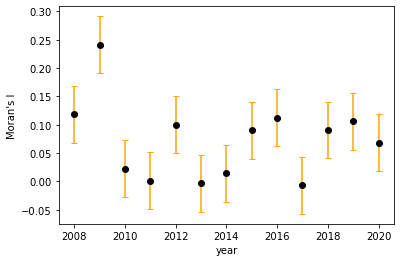

In [53]:
plt.plot()
plt.errorbar(MoransIdf.iloc[:,0], MoransIdf.iloc[:,1], yerr = MoransIdf.iloc[:,4],fmt = 'o',color = 'black', 
            ecolor = 'orange', capsize=3)
plt.xlabel("year")
plt.ylabel("Moran's I")


# Spatial Regression 

With the weight of authorities, we can compute spatial regression as following:

Since the spatial regression has the form:
$$y=Wy \rho  + X\beta +\epsilon$$

This can also be cconverted to a matrix form:
$$y = \begin{pmatrix}
Wy & X
\end{pmatrix}\begin{pmatrix}
\rho\\
\beta
\end{pmatrix} +\epsilon$$

which is essentially a normal linear regression model but appended with spatial variables.

In [54]:
eigenvalueW = np.linalg.eig(weightmat)[0]
APLEvec = np.zeros(9)
for i in range(9): 
    upperfrac_b = Residual_mat[:,i].T@((weightmat+weightmat.T)/2)@Residual_mat[:,i]
    lowerfrac_A = Residual_mat[:,i].T@(weightmat@weightmat.T-np.outer(eigenvalueW,eigenvalueW)@np.eye(len(eigenvalueW))/len(eigenvalueW))@Residual_mat[:,i]
    #APLE = np.linalg.solve(lowerfrac_A,upperfrac_b)
    APLEvec[i] = upperfrac_b/lowerfrac_A
    np.linalg.norm(APLEvec)
APLEvec

array([0.03865806, 0.02350941, 0.01013138, ..., 0.12596295, 0.06899751,
       0.00775451])

In [55]:
#Get the spatial part Wy
spatialtemp = weightmat@yvec

#Initialize a dataframe with 9 years of coefficient
spatlinreg_tsdf = pd.DataFrame(data = np.zeros([len(list(range(2012,2021)))*len(xvariable)+1,6]),columns=['variablename','lag=4','lag=3','lag=2','lag=1','lag=0'])
spatlinreg_tsdf.iloc[0,0] = 'Constant'
#Initialize a dataframe with 13 years of pvalue
spatlinreg_tsdfpval = pd.DataFrame(data = np.zeros([len(list(range(2012,2021)))*len(xvariable)+1,6]),columns=['variablename','lag=4','lag=3','lag=2','lag=1','lag=0'])
spatlinreg_tsdfpval.iloc[0,0] = 'Constant'


for varind in range(len(xvariable)):
    for i in range(8,17):
        spatlinreg_tsdf.iloc[varind*9+i-7,0] = 'Unemployment'+','+str(year[i])+', with respect to '+ variable[xvariable[varind]]
        spatlinreg_tsdfpval.iloc[varind*9+i-7,0] = 'Unemployment'+','+str(year[i])+', with respect to '+ variable[xvariable[varind]]


#iterate over years from year 2008 to 2020: (2008 corresponds to 4th column of stdvalue and 2020 corresponds to 17th column of stdvalue)
for i in range(8,17):    
    #compute all regression using initialized function for xmat and yvec, starting from 2012
    yvec,xmat = Initializationtsyear(i,timelength)
    #Get the yvec after considering spatial lags
    yvec = yvec-APLEvec[i-8]*weightmat@yvec
    resultsvec = sm.OLS(yvec,xmat).fit()
    spatlinreg_tsdf.iloc[0,5] = resultsvec.params[0]
    spatlinreg_tsdfpval.iloc[0,5]=resultsvec.pvalues[0]
    #get the pvalue for coefficient between unemployment and earnings for year i 
    for varind in range(len(xvariable)):
        for timeind in range(timelength+1):
            spatlinreg_tsdf.iloc[varind*9+i-7,timeind+1] = resultsvec.params[varind*(timelength+1)+1+timeind]
            spatlinreg_tsdfpval.iloc[varind*9+i-7,timeind+1]=resultsvec.pvalues[varind*(timelength+1)+1+timeind]
            
#show the result
spatlinreg_tsdf 



,variablename,lag=4,lag=3,lag=2,lag=1,lag=0
0,Constant,0.000000,0.000000,0.000000,0.000000,-0.051107
1,"Unemployment,2012, with respect to Economic ac...",-0.024014,-0.018697,-0.007018,-0.051307,0.162037
2,"Unemployment,2013, with respect to Economic ac...",0.077695,-0.060861,0.061026,0.040560,0.034958
3,"Unemployment,2014, with respect to Economic ac...",0.115752,-0.042662,0.002058,0.063230,-0.041175
4,"Unemployment,2015, with respect to Economic ac...",0.052951,0.018534,-0.001666,-0.072072,0.080038
...,...,...,...,...,...,...
122,"Unemployment,2016, with respect to population_...",-0.273811,0.451190,-0.832571,1.163501,-0.687128
123,"Unemployment,2017, with respect to population_...",0.354918,-0.696834,0.604189,0.190930,-0.491427
124,"Unemployment,2018, with respect to population_...",-0.947075,1.524471,-0.460169,-0.154350,-0.020484
125,"Unemployment,2019, with respect to population_...",-0.127462,-0.124394,0.810927,-0.832172,0.301385


In [56]:
#here we return the coefficient for betas for earning variables:
spatlinreg_tsdf[109:118]

,variablename,lag=4,lag=3,lag=2,lag=1,lag=0
109,"Unemployment,2012, with respect to earnings",-0.106309,0.131456,-0.235974,0.113228,-0.080183
110,"Unemployment,2013, with respect to earnings",-0.110955,-0.115769,-0.206879,-0.228199,0.048036
111,"Unemployment,2014, with respect to earnings",-0.178064,0.020351,-0.087916,-0.224512,-0.148459
112,"Unemployment,2015, with respect to earnings",-0.019655,0.114213,-0.147501,-0.099318,-0.057228
113,"Unemployment,2016, with respect to earnings",-0.219288,-0.121716,0.022911,0.038142,0.246591
114,"Unemployment,2017, with respect to earnings",0.086024,-0.056378,-0.069458,-0.053852,0.105961
115,"Unemployment,2018, with respect to earnings",-0.024730,0.132399,-0.250699,0.219553,-0.166818
116,"Unemployment,2019, with respect to earnings",-0.175097,0.161415,-0.242240,-0.135665,-0.077407
117,"Unemployment,2020, with respect to earnings",0.096564,-0.325295,0.041773,-0.149237,-0.089788


In [57]:
#here we return the pvalue for betas for earning variables:
spatlinreg_tsdfpval[109:118]

,variablename,lag=4,lag=3,lag=2,lag=1,lag=0
109,"Unemployment,2012, with respect to earnings",0.235921,0.327891,0.074729,0.397534,0.582354
110,"Unemployment,2013, with respect to earnings",0.421590,0.459869,0.181602,0.191733,0.769186
111,"Unemployment,2014, with respect to earnings",0.144847,0.869130,0.536260,0.081477,0.337151
112,"Unemployment,2015, with respect to earnings",0.861226,0.390507,0.210010,0.490759,0.660404
113,"Unemployment,2016, with respect to earnings",0.123566,0.364435,0.893257,0.803925,0.079005
114,"Unemployment,2017, with respect to earnings",0.549593,0.744137,0.657653,0.741320,0.506536
115,"Unemployment,2018, with respect to earnings",0.879040,0.409417,0.114133,0.186026,0.174639
116,"Unemployment,2019, with respect to earnings",0.231451,0.260064,0.098079,0.253136,0.340218
117,"Unemployment,2020, with respect to earnings",0.574234,0.073636,0.777596,0.153396,0.370648
